# Let Us Help You: Using the PaLM 2 and Cody LLMs for Graph Data Science
*Last Updated 16 October 2023*

This notebook demonstrates how to use Google's PaLM 2 and Cody LLMs together in a single graph data science workflow. The data and use case are leveraged from the Road to NODES 2023 Presentation: [Neo4j GDS and GenAI](https://github.com/danb-neo4j/NODES2023_GDS_GenAI).

# Import Libraries

In [1]:
# core libraries
import os
import time
import logging
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# libraries to display GCP LLM output 
from IPython.display import Markdown, display

In [3]:
# gcp and vertex AI 
from google.cloud import aiplatform
import vertexai
from vertexai.preview.language_models import TextGenerationModel, ChatModel, CodeGenerationModel, CodeChatModel

2023-10-14 18:35:26.586545: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# library to protect secrets
import getpass

In [5]:
# install or import Neo4j GraphDataScience library
try: 
  from graphdatascience import GraphDataScience
  print('Successfully imported GraphDataScience')
except ModuleNotFoundError:
  !pip install graphdatascience
  from graphdatascience import GraphDataScience
  print('installed and imported GraphDataScience')

Successfully imported GraphDataScience


In [6]:
# limit warnings 
import warnings
warnings.filterwarnings("ignore")

# Conect and Authenticate to GCP
This will enable us to access GDS resources, including the PaLM 2 LLM models.

In [9]:
# set GCP project id
PROJECT_ID = getpass.getpass()

In [10]:
# set GCP region 
REGION = getpass.getpass()

In [11]:
# initialize vertexai wth ID and region 
vertexai.init(project=PROJECT_ID, location=REGION)

In [55]:
# run the below in the jupyter terminal to authenticate your google account
# ! gcloud auth login

In [12]:
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


# Instantiate LLM Models
In the following section we will instantiate and test four types of Google PaLM 2 and Cody models, each of which is fine-tuned for a specific task:
* Text Generation
* Text Chat
* Code Generation
* Code Chat

All four of the modesl we instantiate will be the most recent 32k versions, as of Google Next 2023 in August 2023. 

Throughout this notebook we will experiment with these speciality models to see how they perform in different situations. 

In [13]:
# function to print markdown returned by GCP models
def print_markdown(string):
    display(Markdown(string))

## Text Bison 32k Text Generation Model
[Link to documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/text)

*The text-bison foundation model is optimized for a variety of natural language tasks such as sentiment analysis, entity extraction, and content creation. The types of content that the text-bison model can create include document summaries, answers to questions, and labels that classify content.*

In [54]:
# instantiate a model object
textGen_model = TextGenerationModel.from_pretrained("text-bison-32k")

In [55]:
# create a parameter dictionary 
textGen_parameters = {
    "temperature": 0.2,  # default is 0.0; 0.2 is a recommended start
    "max_output_tokens": 8192,  
    "top_p": 0.8,  
    "top_k": 40,  
}

## Chat Bison 32k Chat Model
[Link to documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/text-chat)

*The chat-bison foundation model is a large language model (LLM) that excels at language understanding, language generation, and conversations. This chat model is fine-tuned to conduct natural multi-turn conversations, and is ideal for text tasks about code that require back-and-forth interactions.*

In [17]:
# instantiate the model object
textChat_model = ChatModel.from_pretrained("chat-bison-32k")

In [18]:
# create a parameter dictionary 
textChat_parameters = {
    "temperature": 0.2,  # default is 0.0; 0.2 is a recommended start
    "max_output_tokens": 8192,  
    "top_p": 0.8,  
    "top_k": 40,  
}

## Code Bison 32k Code Generation Model
[Link to documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/code-generation)

*code-bison is a foundation model that generates code based, including functions, web pages, and unit tests, based upon a natural language description. This model is ideal for interactions that require a single interaction with the model, as compared to the chat version specified below.* 

In [82]:
# instantiate a model object
codeGen_model = CodeGenerationModel.from_pretrained("code-bison-32k")

In [83]:
# create a parameter dictionary 
codeGen_parameters = {
    "temperature": 0.2, # same as the default value 
    "max_output_tokens": 8192
}

## CodeChat Bison 32k Code Chat Model
[Link to documentation](https://cloud.google.com/vertex-ai/docs/generative-ai/model-reference/code-chat)

*codechat-bison is a foundation model that supports multi-turn conversations that are specialized for code. The model allows developers to chat with a chatbot for help with code-related questions. The code chat API is ideal for code tasks that are completed with back-and-forth interactions so you can engage in a continuous conversation.*

In [32]:
# instantiate the codechat model object
codeChat_model = CodeChatModel.from_pretrained('codechat-bison-32k')

In [33]:
# create a parameter object 
codeChat_parameters = {
        "temperature": 0.2, # same as the default value
        "max_output_tokens": 8192
}

In [86]:
# start a chat
codeChat_obj = codeChat_model.start_chat()

# Connect to Neo4j AuraDS Database
We will use getpass below to protect connection and authentication details.

In [45]:
# AuraDS host link 
HOST = getpass.getpass()

 ········


In [46]:
# AuraDS database username 
USERNAME = getpass.getpass()

 ········


In [47]:
# AuraDS password
NEO4J_PASSWORD = getpass.getpass()

 ········


In [48]:
# connect to AuraDS and confirm connection via GDS version 
gds = GraphDataScience(HOST, auth=(USERNAME, NEO4J_PASSWORD), aura_ds=True)
print('Neo4j GDS Version:', gds.version())

Neo4j GDS Version: 2.4.7+35


# Ask LLM for High-Level Analytic Guidance
First we will ask the LLM for high-level guidance about analyzing the LLM's answers. We will use the `text-bison` model here because we only need a single response at this point. As we begin to perform different analyses, we will switch to `chat-bison` for question and answering. 

In [58]:
# test the model with a response 
message_text = """
You are an experienced graph data scientist who works at Neo4j and are known
for providing helpful advice.

Help me brainstorm approaches to analyze data from an LLM application I am logging in a Neo4j graph database. 
Applicaiton users ask questions to the LLM about the Neo4j Graph Data Science library,
and the LLM answers those questions with help from context documentation, which is contained in the same Neo4j database. 

The Neo4j database logs user interactions with the LLM via the following graph data model:
(s:Session)-[HAS_CONVERSATION]->(c:Conversation)-[FIRST]->(m:Message)-[NEXT]->(a:Assistant)

The (m:Message) nodes represent user questions to the LLM and the (a:Assistant) nodes
represent the LLM's response. For each (c:Conversation) the pattern (m:Message)-[NEXT]->(a:Assistant) 
will repeat for as long as the user continues the conversation.

A session can have multiple conversations, and a conversation can have many messages. 
Each message can be connected to up to 10 context Documents as follows:
(m:Message)-[HAS_CONTEXT]->(d:Document)

Messages can, and often do, share context Documents.

Provide me with high-level traditional and graph-based approaches for analyzing the (a:Assistant) responses
with the goal of understanding how well the LLM is performing and how we may aim
to improve the application.
"""

textGen_response = textGen_model.predict(
    message_text,
    **textGen_parameters
)

print_markdown(textGen_response.text)

 Here are some high-level approaches for analyzing the (a:Assistant) responses with the goal of understanding how well the LLM is performing and how we may aim to improve the application:

### Traditional Approaches:

- **Sentiment Analysis**: Analyze the sentiment of the (a:Assistant) responses to understand the overall user satisfaction with the LLM's performance. This can be done by using traditional sentiment analysis techniques such as the VADER (Valence Aware Dictionary and sEntiment Reasoner) algorithm.

- **Topic Modeling**: Apply topic modeling techniques such as Latent Dirichlet Allocation (LDA) to identify the main topics discussed in the conversations. This can help understand the areas where the LLM is performing well and where it needs improvement.

- **Named Entity Recognition**: Use named entity recognition techniques to identify important entities mentioned in the conversations, such as specific Neo4j Graph Data Science library functions or concepts. This can help understand the specific areas where users are seeking assistance from the LLM.

### Graph-based Approaches:

- **Network Analysis**: Represent the conversations as a graph where nodes represent (m:Message)s and (a:Assistant)s, and edges represent the "NEXT" relationship between them. Analyze the resulting graph to identify patterns, such as the most frequent conversation paths or the most frequently asked questions.

- **Community Detection**: Apply community detection algorithms to identify groups of conversations that are topically similar. This can help understand the different areas of interest among users and how the LLM is addressing them.

- **Link Prediction**: Use link prediction algorithms to predict the next (a:Assistant) response given a sequence of (m:Message)s. This can help evaluate the LLM's ability to generate coherent and contextually relevant responses.

These are just a few examples of approaches that can be used to analyze the (a:Assistant) responses in the Neo4j graph database. The specific approach or combination of approaches to use will depend on the specific goals and requirements of the analysis.

# Analyze LLM Responses

## Conversations per User Session 
This statistic will calculate the number of distinct conversation a user has per session. We are calculating it to identify how users are broadly interacting with the Agent Neo application. 

### Generate the Statistics

In [70]:
# update conversation_count property on Session nodes
gds.run_cypher('''
MATCH (s:Session)-[r:HAS_CONVERSATION]->(c:Conversation)
WITH s, count(c) AS conversation_count
SET s.conversation_count = conversation_count
''')

""


### Analyze Statistics

In [93]:
# generate dataframe with sessions and conversation count
session_count = gds.run_cypher('''
MATCH (s:Session) 
RETURN 
    s.id AS id,
    s.conversation_count as conversation_count
''')

session_count.shape

(69, 2)

In [94]:
# generate a distribution 
session_dist = session_count['conversation_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]).round()
session_dist

count    69.0
mean      1.0
std       1.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
90%       2.0
95%       3.0
99%       5.0
99.9%     6.0
max       6.0
Name: conversation_count, dtype: float64

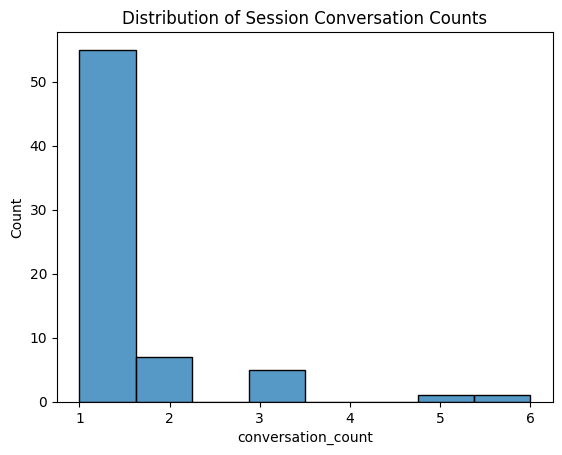

In [95]:
# plot the distribution 
sns.histplot(data=session_count, x='conversation_count')
plt.title('Distribution of Session Conversation Counts')
plt.show()

### Ask LLM for Interpretation

In [96]:
# start chat with a context prompt
textChat_obj = textChat_model.start_chat(
    context="You are an experienced graph data scientist who works at Neo4j."
)

In [97]:
# ask ChatBison for its interpretation of the distribution 
prompt = f"""
Help me interpret the results of the following Session Conversation 
Distribution: {session_dist}

This distribution is from conversation logging for an LLM application. The distribution
counts the number of distinct conversations application users have per session. 

As the application's technical project manager, how should I interpret these results
to understand user behavior and identify ways to improve the applicaiton and user
experience?
"""

textChat_response = textChat_obj.send_message(prompt, **textChat_parameters)

print_markdown(textChat_response.text)

 The distribution of session conversation counts shows that the majority of users (69%) have only one conversation per session. The mean and median number of conversations per session is also 1, indicating that the distribution is skewed towards users having few conversations per session. 

This could be interpreted in a few ways. One possibility is that users are not finding the application engaging enough to have multiple conversations per session. Another possibility is that the application is not providing users with enough value to warrant multiple conversations per session. 

To improve the application and user experience, you could consider ways to make the application more engaging and valuable to users. This could include adding new features, improving the user interface, or providing more relevant content. You could also consider ways to encourage users to have multiple conversations per session, such as by offering incentives or rewards.

## Conversation Length
This statistic will count the number of messages per each conversation. Note that each question and answer is one message, so dividing the total by two will approximate the number of questions the user asks. These statistics will help understand in more detail how many questions it takes for users to get the answer they need or otherwise abandon the application (when combined with user ratings, to be analyzed later). 

### Ask LLM to Help Generate Code
First, we will ask code-bison for help generating Cypher code to produce the conversation length counts.

In [87]:
# request a function from a natural language prompt 
message_text = """
I want you to help me write Cypher code for Neo4j.
I have the following graph data model:
(c:Conversation)-[FIRST]->(:Message)-[NEXT]->(:Message)

I want to count the number of total (:Message) nodes connected
to each individual (c:Converation) nodes. For each (c:Conversation)
the pattern (:Message)-[NEXT]->(:Message) can continue for as long as 
the user continues ot ask quesitons. 

Provide Neo4j 5.0 Cypher compliant code to count these (:Message) nodes and set a new 
parameter on the (c:Conversation) node called 'conversation_length'. 
"""

codeGen_response = codeGen_model.predict(
                        prefix = message_text, 
                        **codeGen_parameters
                    )

print_markdown(codeGen_response.text)

```cypher
MATCH (c:Conversation)-[:FIRST]->(m:Message)
WITH c, m, size((m)-[:NEXT*]->()) AS conversation_length
SET c.conversation_length = conversation_length
RETURN c.conversation_length
```

### Ask LLM to Help Debug Generated Code
The initial code above produced a syntax error when run, so we will ask the codechat-bison model to help debug it. 

In [88]:
# make a second request, referencing the first 
message_text = """
I have the following graph data model:
(c:Conversation)-[FIRST]->(:Message)-[NEXT]->(:Message)

My objective is to count the number of (:Message)
nodes associated with each (c:Conversation) node in my graph. 

Help me debug the following Neo4j 5.0 Cypher code,
provided between the four #s below:

####
MATCH (c:Conversation)-[:FIRST]->(m:Message)
WITH c, m, size((m)-[:NEXT*]->()) AS conversation_length
SET c.conversation_length = conversation_length
RETURN c.conversation_length
####

When I run it I receive the following error from Neo4j:
####
Neo.ClientError.Statement.SyntaxError
A pattern expression should only be used in order to test the existence of a pattern. It can no longer be used inside the function size(), an alternative is to replace size() with COUNT {}. (line 2, column 17 (offset: 61))
"WITH c, m, size((m)-[:NEXT*]->()) AS conversation_length"
###

Provide updated, corrected Neo4j 5.0 compliant Cypher code.
"""

codeChat_response = codeChat_obj.send_message(
    message = message_text, 
    **codeChat_parameters
) 

print_markdown(codeChat_response.text)

 The error message indicates that the `size()` function is no longer supported inside the `WITH` clause in Neo4j 5.0. 

To resolve this error, you can replace the `size()` function with the `COUNT()` function, which serves a similar purpose. 

The corrected Cypher code would be:

```
MATCH (c:Conversation)-[:FIRST]->(m:Message)
WITH c, m, COUNT((m)-[:NEXT*]->()) AS conversation_length
SET c.conversation_length = conversation_length
RETURN c.conversation_length
```

In [89]:
# make a second request, referencing the first 
message_text = """
The updated code also returns a similar error when I attempt to run it.

####
Neo.ClientError.Statement.SyntaxError
A pattern expression should only be used in order to test the existence of a pattern. It should therefore only be used in contexts that evaluate to a boolean, e.g. inside the function exists() or in a WHERE-clause. No other uses are allowed, instead they should be replaced by a pattern comprehension. (line 2, column 18 (offset: 62))
"WITH c, m, COUNT((m)-[:NEXT*]->()) AS conversation_length"
###

Is there an alternative approach to achieve my objective?
Please provide Neo4j 5.0 compliant Cypher code that accomplishes this in another way.
"""

codeChat_response = codeChat_obj.send_message(
    message = message_text, 
    **codeChat_parameters
) 

print_markdown(codeChat_response.text)

 Here is an alternative approach to achieve your objective using Neo4j 5.0 compliant Cypher code:

```
MATCH (c:Conversation)-[:FIRST]->(m:Message)
WITH c, m
CALL {
  WITH m, c
  MATCH (m)-[:NEXT*]->(n)
  RETURN COUNT(n) AS conversation_length
}
SET c.conversation_length = conversation_length
RETURN c.conversation_length
```

This code uses a combination of the `WITH` clause and a `CALL` statement to achieve the desired result. 

The `WITH` clause is used to pass the `c` and `m` nodes to the `CALL` statement. 

The `CALL` statement then executes a subquery that calculates the number of `(:Message)` nodes associated with each `(c:Conversation)` node. 

The result of the subquery is then assigned to the `conversation_length` property of the `c` node.

In [91]:
# final udpate to the code 
message_text = """
The updated code appears to be running, but it is missing the count
of total conversations by 1 because it does not include the first 
(m:Message) node. Can you provide updated code so that it counts
all (m:Message) nodes including the first?
"""

codeChat_response = codeChat_obj.send_message(
    message = message_text, 
    **codeChat_parameters
) 

print_markdown(codeChat_response.text)

 Here is an updated version of the code that includes the count of the first (m:Message) node:

```
MATCH (c:Conversation)-[:FIRST]->(m:Message)
WITH c, m
CALL {
  WITH m, c
  MATCH (m)-[:NEXT*]->(n)
  RETURN COUNT(n) + 1 AS conversation_length
}
SET c.conversation_length = conversation_length
RETURN c.conversation_length
```

The updated code adds 1 to the count of the (m:Message) nodes to include the first node in the count.

### Run the Code to Generate Statistics

In [90]:
# create new property on Conversation nodes
gds.run_cypher('''
MATCH (c:Conversation)-[:FIRST]->(m:Message)
WITH c, m
CALL {
  WITH m, c
  MATCH (m)-[:NEXT*]->(n)
  RETURN COUNT(n) + 1 AS conversation_length
}
SET c.conversation_length = conversation_length
RETURN c.conversation_length
''') 

""


### Analyze Statistics

In [98]:
# generate dataframe for each conversation length 
conversation_lengths = gds.run_cypher('''
MATCH (c:Conversation)
RETURN 
    c.id AS id,
    c.conversation_length AS conversation_length
''')

conversation_lengths.shape

(95, 2)

In [99]:
# generate distribution for conversation lengths 
convo_len_dist = conversation_lengths['conversation_length'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]).round()
convo_len_dist

count    95.0
mean      5.0
std       4.0
min       1.0
25%       2.0
50%       4.0
75%       6.0
90%      10.0
95%      13.0
99%      18.0
99.9%    23.0
max      24.0
Name: conversation_length, dtype: float64

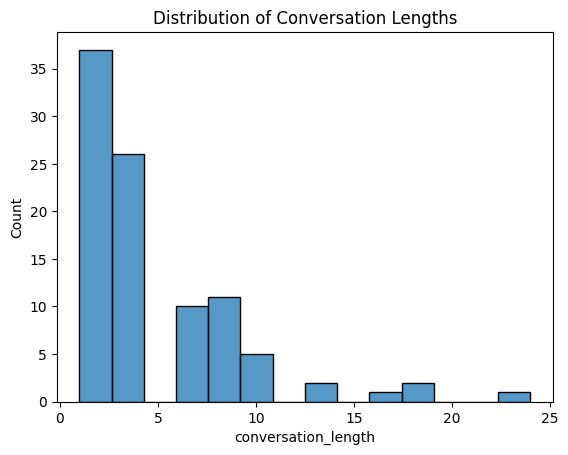

In [100]:
# plot conversation lengths 
sns.histplot(data=conversation_lengths, x='conversation_length')
plt.title('Distribution of Conversation Lengths')
plt.show()

### Ask LLM for Interpretation

In [101]:
# ask ChatBison for its interpretation of the conversation length distribution 
prompt = f"""
Continuing the conversation, help me interpret the results of the Conversation Length
Distribution, which is the length of each individual conversation a user has
with the LLM in the application.

The conversation length distribution is in the following object: {convo_len_dist}

As the application technical project manager, how should I interpret these results?
What might they indicate for the quality of the application and how we might improve it?
"""

textChat_response = textChat_obj.send_message(prompt, **textChat_parameters)

print_markdown(textChat_response.text)

 The conversation length distribution shows that the majority of conversations (95%) are 10 or fewer messages long, with the average conversation length being 5 messages. This indicates that users are generally having short, concise conversations with the LLM. 

This could be interpreted in a few ways. One possibility is that users are finding the LLM to be helpful and informative, and are able to get their questions answered quickly and easily. Another possibility is that users are not finding the LLM to be engaging enough to have longer conversations. 

To improve the application and user experience, you could consider ways to make the LLM more engaging and helpful to users. This could include adding new features, improving the LLM's knowledge base, or providing more relevant content. You could also consider ways to encourage users to have longer conversations, such as by offering incentives or rewards.

### Interpret both Statistical Distributions Together
Finally, we will leverage the 'memory' in the chat object to have the LLM analyze both distributions together to see if it produces new insights. 

In [102]:
prompt = f"""
How should I interpret the conversation length distribution along with the 
prior session conversation distribution?
"""

textChat_response = textChat_obj.send_message(prompt, **textChat_parameters)

print_markdown(textChat_response.text)

 Taken together, the conversation length distribution and the prior session conversation distribution provide insights into how users are interacting with the LLM application. 

The conversation length distribution shows that the majority of conversations are short, with the average conversation length being 5 messages. This suggests that users are generally using the LLM to ask quick questions or get brief information. 

The prior session conversation distribution shows that the majority of users (69%) have only one conversation per session. This suggests that users are not returning to the application for multiple conversations. 

These two distributions could be interpreted in a few ways. One possibility is that users are not finding the LLM application to be engaging enough to have multiple conversations. Another possibility is that the LLM is not providing users with enough value to warrant multiple conversations. 

To improve the application and user experience, you could consider ways to make the LLM more engaging and valuable to users. This could include adding new features, improving the LLM's knowledge base, or providing more relevant content. You could also consider ways to encourage users to have multiple conversations, such as by offering incentives or rewards.